# TME1
#### Borchani Sofia (21212080) 
#### Bouchouchi Nour (28600211)


In [205]:
import numpy as np
import sklearn
from sklearn import datasets, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D



In [206]:
np.random.seed(42)

# 1. Données


In [207]:
#x : coordonnées des points
#y : labels des points
x1,y1 = datasets.make_moons(n_samples=500, shuffle=True, noise=None, random_state=None)
x2,y2 = datasets.make_moons(n_samples=500, shuffle=True, noise=0.1, random_state=None)
x3,y3 = datasets.make_moons(n_samples=500, shuffle=True, noise=0.2, random_state=None)
x4,y4 = datasets.make_moons(n_samples=500, shuffle=True, noise=0.3, random_state=None)

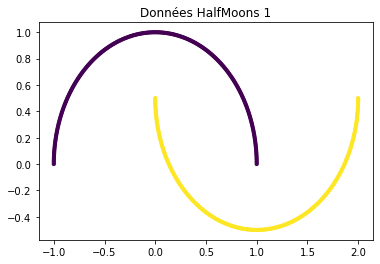

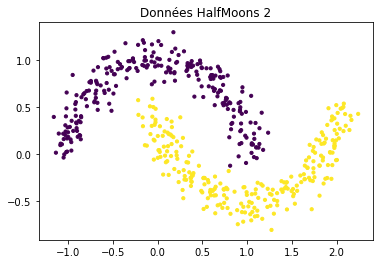

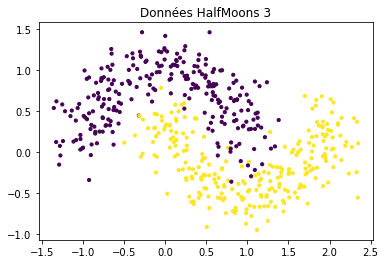

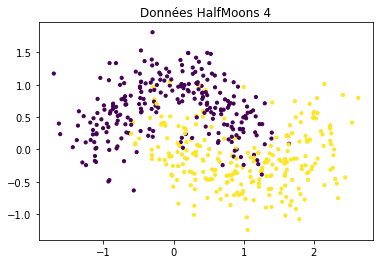

In [208]:
x_list = [x1, x2, x3, x4]
y_list = [y1, y2, y3, y4]

for i in range(len(x_list)):
    plt.figure()
    plt.scatter([point[0] for point in x_list[i]], [point[1] for point in x_list[i]], c=y_list[i], s=10)
    plt.title(f'Données HalfMoons {i+1}')
    plt.show()

Nous avons généré et affiché des bases de données de type halfMoons pour quatre niveaux de bruit différents : sans bruit, puis avec un bruit de 0.1, 0.2 et enfin 0.3. On observe que la séparation des deux classes est parfaite dans les deux premiers cas puis qu'à mesure que le bruit augmente cette séparation n'est plus parfaite et certains points sont plus difficile à associer à une classe précise.

## 2. Classifieurs

Nous avons décidé de nous concentrer par la suite sur les données avec un bruit 0.2 pour lesquelles la séparation des deux classes n'est pas parfaite. 

In [209]:
X_data, Y_data = x3, y3

On commence par séparer les données entre ensemble test et train.

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

### SVM

On implémente différents classifieurs de type SVM, k-ppv et forêt aléatoire 

In [211]:
svm = svm.SVC()
svm.fit(X_train, y_train)

SVC()

In [212]:
yhat_svm = svm.predict(X_test)
print("accuracy : ", accuracy_score(y_test,yhat_svm))

accuracy :  0.96


### k-ppv

In [213]:
knn = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=2)

In [214]:
yhat_knn = knn.predict(X_test)
print("accuracy : ", accuracy_score(y_test,yhat_knn))

accuracy :  0.95


### foret aléatoire

In [215]:
forest = RandomForestClassifier(max_depth=2, random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [216]:
yhat_forest = forest.predict(X_test)
print("accuracy : ", accuracy_score(y_test,yhat_forest))

accuracy :  0.92


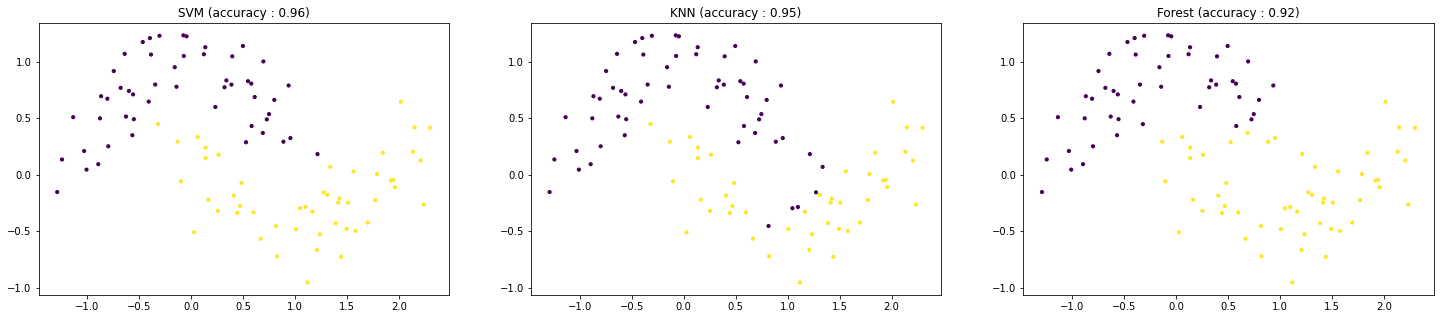

In [217]:
fig, axes = plt.subplots(1, 3, figsize=(25,5))
axes[0].scatter(X_test[:,0],X_test[:,1], c = yhat_svm, s=10)
axes[0].set_title('SVM (accuracy : %.2f)' % accuracy_score(y_test,yhat_svm))
axes[1].scatter(X_test[:,0],X_test[:,1], c = yhat_knn, s=10)
axes[1].set_title('KNN (accuracy : %.2f)' % accuracy_score(y_test,yhat_knn))
axes[2].scatter(X_test[:,0],X_test[:,1], c = yhat_forest, s=10)
axes[2].set_title('Forest (accuracy : %.2f)' % accuracy_score(y_test,yhat_forest))
plt.show()

On remaeque que les trois classifieurs obtiennent des scores d'accuracy relativement élevés, mais ils ont des performances différentes sur le dataset de test en raison de la manière dont ils gèrent les points ambigus et de la nature de leur algorithme de classification.

Le SVM est le classificateur le plus performant dans ce cas. Cela peut s'expliquer par sa capacité à trouver des hyperplans de décision complexes qui peuvent mieux séparer les classes non linéaires comme les demi-lunes. 

En revanche, le KNN a des performances plus faibles dans ce cas car il se base sur la proximité des voisins pour effectuer la classification et aura donc plus de mal à classifier les points se trouvant dans une région ambigue. 

Enfin, le Random Forest, peut ne pas bien capturer la répartition en demi-lune des deux classes en raison de la nature de la classification par un arbre de décision qui ne trace donc que des frontières de décision perpendiculaires aux axes. 

## 3. Génération d'exemples contrefactuels

In [218]:
def SL(x,a0,a1,n):
    """
    Génère n points dans la couche sphérique de centre x et de rayon interne a0 et de rayon externe a1
    x : centre de la sphere 
    a0 : rayon interne
    a1 : rayon externe
    n : nombre de points générés 
    """
    d = x.shape[0] #dimension des données
    z = np.random.normal(0,1,(n,d)) # on génère des points suivant une loi normal

    norms = np.linalg.norm(z, axis=1) # on calcule la norme par ligne 
    z = z / norms[:, np.newaxis] # on divise chaque ligne par sa norme 
    
    u = (np.random.uniform(a0**d,a1**d,n))**(1/d)

    res = x + z*u[:,np.newaxis] #
    return res 

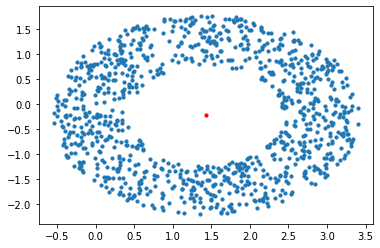

In [219]:
res =SL(X_test[0],1,2,1000)

plt.figure()
plt.scatter(res[:,0],res[:,1], s=10)
plt.scatter(X_test[0][0],X_test[0][1], s=10, c ='r')
plt.show()

In [220]:
def GS(f,x,eta,n):
    """
    Algorithme des growking sphere : retourne l'enemy le plus proche de x  avec la distance l2 minimale (point de classe opposé le plus proche de x)
    f : classifieur binaire
    x : observation à interpréter
    eta : épaisseur de la sphere 
    n : nombre de points générés  
    """
    z = SL(x, 0, eta, n)
    predict_x = f.predict([x])

    while(not np.all(predict_x == f.predict(z))): 
        eta = eta/2
        z = SL(x,0,eta,n)

    a0 = eta
    a1 = 2*eta

    while (np.all(predict_x== f.predict(z))):
        z = SL(x,a0,a1,n)
        a0 = a1
        a1 += eta

    liste_e = z[np.where(predict_x != f.predict(z))[0]] #liste des enemy
    l2 = np.sqrt( np.sum((x - liste_e)**2, axis=1) ) #distance l2 calculée pour chaque enemy


    return liste_e[np.argmin(l2)] #selection de l'enemy avec la distance l2 minimale 


In [221]:
e = GS(svm, X_test[0],0.5,50)
print("La classe prédite pour x " + str(X_test[0]) + " est " + str(svm.predict([X_test[0]])))
print("La classe prédite pour e " + str(e) + " est " + str(svm.predict([e])))

La classe prédite pour x [ 1.42418679 -0.21167993] est [1]
La classe prédite pour e [1.10762047 0.01738242] est [0]


In [222]:
def feature_selection(f,x,e):
    """    
    Retourne l'enemy qui minimise le nombre d’attributs modifiés
    f : classifieur binaire
    x : observation à interpréter
    e : enemy le plus proche de x au sens l2
    """
    e_prim = e.copy()
    e_star = e_prim.copy()
    while f.predict([e_prim]) != f.predict([x]) :
        e_star = e_prim.copy()
        ind = np.where(e_prim != x )[0] 
        abs = np.absolute(e_prim[ind]-x[ind]) #valeurs absolues des différences entre e_prim_j et x_j (tels que : e_prim_j != x_j  )
        i = ind[np.argmin(abs)]
        e_prim[i] = x[i]
    
    return e_star


In [223]:
x = X_test[3]

e = GS(svm, x,0.5,50)


print("Point initial :", x)
print("e : ", e)
print("e* de ce point : ", feature_selection(svm,x,e))

Point initial : [0.95267809 0.32307011]
e :  [ 0.90116768 -0.06883857]
e* de ce point :  [ 0.95267809 -0.06883857]


On observe ici que le point e* parcimonieux n'est pas le même que le point enemy e le plus proche de x. En effet, pour e_star, l'abscisse est identique à celle de x mais que l'ordonnée est différente, on ne touche donc qu'à un seul attribut contrairement à l'enemy e qui était retourné par GS où les deux attributs étaient différents. 

## 4. Visualisation

### Exemple en 2 dimensions

In [224]:
def affiche_frontiere2D(f,X_train): 
   """    
   Affiche la frontière de décision d'une classifieur
   f : classifieur binaire
   X_train : les données d'apprentissage  
   """


# Génération d'une grille
   x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
   y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
   xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

   # Prédiction chaque point de la grille
   Y = f.predict(np.c_[xx.ravel(), yy.ravel()])
   Y = Y.reshape(xx.shape)

   # Affichage de la frontière de décision
   plt.contourf(xx, yy, Y, cmap=plt.cm.coolwarm, alpha=0.5)


In [225]:
def visualise(f, X, y, X_train,eta=0.1,n=100,stable=None):
    """    
    Permet de visualiser les données, la frontière de décision, une donnée à expliquer ainsi que l'exemple contrfactuel associé 
    f : classifieur binaire
    X : observations à interpréter
    y : lables associés 
    X_train : les données d'apprentissage 
    eta : épaisseur de la sphere 
    n : nombre de points générés  
    stable : étude de la stabilité 
    """
    
    plt.figure()
    
    affiche_frontiere2D(f,X_train)

    plt.scatter(X[:,0],X[:,1], c=y, s=10)
    
    x = X[np.random.randint(X.shape[0])]
    print("coordonées de x :",x)
    red = plt.scatter([x[0]], [x[1]], c='red', s=60) #donnée à expliquer
    
    e = GS(f,x,eta,n)
    green = plt.scatter([e[0]], [e[1]], c='green', s=60) #exemple contrefactuel
    print("coordonées de e :",e)
    
    e_star = feature_selection(f,x,e)
    blue = plt.scatter([e_star[0]], [e_star[1]],c='blue', s=30) #exemple contrefactuel
    print("coordonées de e* :",e_star)

    
    plt.legend([red, green, blue],["x","e","e*"])
    plt.show()
    
    
    
    if stable == True:
        
        
        distances = np.linalg.norm(X - x, axis=1)
        ind = np.argsort(distances)
        ind_voisins = ind[1:11]
        voisins = X[ind_voisins]
        
        plt.figure()
        affiche_frontiere2D(f,X_train)
        plt.scatter(X[:,0],X[:,1], c=y, s=10)
        red = plt.scatter([x[0]], [x[1]], c='red', s=30)
        
        for v in voisins:
            e = GS(f,v,eta,n)
            e_star = feature_selection(f,v,e)
        
            orange = plt.scatter([v[0]], [v[1]], c='orange', s=10)
            blue = plt.scatter([e_star[0]], [e_star[1]],c='blue', s=10) 
            
            x_values = [v[0], e_star[0]]
            y_values = [v[1], e_star[1]]
            plt.plot(x_values, y_values, linestyle='dotted', color='black', linewidth=0.5)
            #print(e_star)
            
        plt.title("Etude des 10 voisins les plus proches du point de référence")
        plt.legend([red, orange, blue],["x","voisins de x","e*"])
        plt.show()
            

In [226]:
np.random.seed(42)

coordonées de x : [1.10031364 0.4707814 ]
coordonées de e : [1.42136709 0.25760413]
coordonées de e* : [1.42136709 0.25760413]


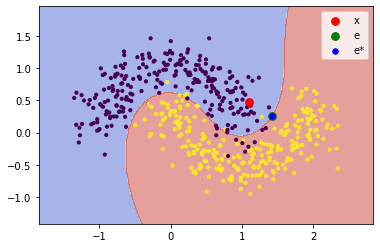

In [227]:
visualise(svm, X_data, Y_data, X_train)

coordonées de x : [2.02790832 0.4844137 ]
coordonées de e : [1.60452049 0.36548972]
coordonées de e* : [1.60452049 0.36548972]


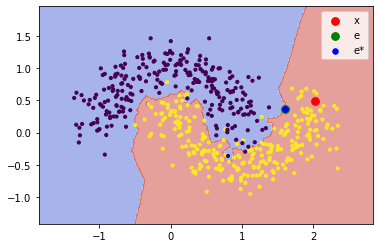

In [228]:
visualise(knn, X_data, Y_data, X_train)

coordonées de x : [ 0.59793087 -0.33428465]
coordonées de e : [0.64319362 0.37814232]
coordonées de e* : [0.59793087 0.37814232]


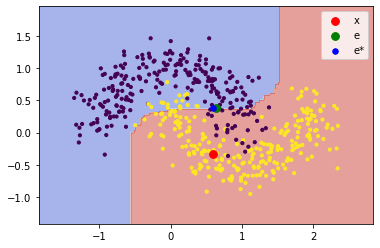

In [229]:
visualise(forest, X_data, Y_data, X_train)

On observe dans ces exemples que pour les classifieurs SVM et KNN les exemples intermédiaire (e) et l'exemple contrefactuel (e*) en vert et bleu respectivemnt sont identiques. Cela s'explique par le fait que le point enemy le plus proche de x (en rouge) est tel que, quelque soit l'attribut pour lequel on modifie la coordonnée de e pour être identique à celle de x, le point obtenu est alors dans la même classe que x. Par conséquent on garde commme exemple contrefactuel le point e intermédiare le plus proche de x.

En revanche, dans l'exemple utilisant le classifieur random forest, on observe bien que les points e et e_star sont distincts. En effet, ici, la modification de l'abscisse de e permet de trouver un point qui se trouve toujours dans la classe opposée à x (bien entendu si l'on modifie également l'ordonnée on tombe sur le point x donc on ne modifie qu'un attribut dans le cas de données en 2D). L'exemple ainsi obtenu est donc notre exemple contrefactuel.  

### Exemple en 3 dimensions


In [230]:
from sklearn.datasets import make_blobs

# Générer des données avec 3 attributs (3 dimensions) et 2 classes
X3d, y3d = make_blobs(n_samples=100, n_features=3, centers=2, cluster_std = 8, random_state=42)



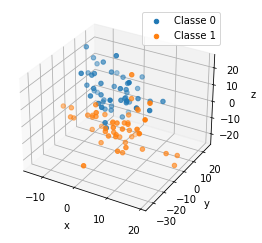

In [231]:
def plot_3d_data(X, y):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Séparation des échantillons par classe
    X_class0 = X[y == 0]
    X_class1 = X[y == 1]

    # Affichage des points pour chaque classe
    ax.scatter(X_class0[:, 0], X_class0[:, 1], X_class0[:, 2], label='Classe 0')
    ax.scatter(X_class1[:, 0], X_class1[:, 1], X_class1[:, 2], label='Classe 1')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')


    plt.legend(loc='best')
    plt.show()

# Utilisation de la fonction pour afficher les données générées précédemment
plot_3d_data(X3d, y3d)

In [232]:
X_train3d, X_test3d, y_train3d, y_test3d = train_test_split(X3d, y3d, test_size=0.2, random_state=42)

svm3d = sklearn.svm.SVC()
svm3d.fit(X_train3d, y_train3d)
yhat_svm3d = svm3d.predict(X_test3d)
print("accuracy : ", accuracy_score(y_test3d,yhat_svm3d))

accuracy :  0.95


coordonées de x : [  3.68591964 -16.84553742  -5.49466219]
coordonées de e : [-0.72932471 -1.79544749 -0.87172168]
coordonées de e* : [-0.72932471 -1.79544749 -0.87172168]


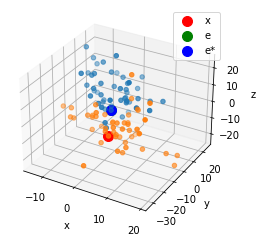

In [233]:
def visualise3D(f, X, y):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Séparation des échantillons par classe
    X_class0 = X[y == 0]
    X_class1 = X[y == 1]

    # Affichage des points pour chaque classe
    ax.scatter(X_class0[:, 0], X_class0[:, 1], X_class0[:, 2])
    ax.scatter(X_class1[:, 0], X_class1[:, 1], X_class1[:, 2])

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    x = X[np.random.randint(X.shape[0])]
    print("coordonées de x :", x)
    red = ax.scatter(x[0], x[1], x[2], c='red', s=100) #donnée à expliquer

    e = GS(f, x, 0.5, 50)
    green = ax.scatter(e[0], e[1], e[2], c='green', s=100) #exemple contrefactuel
    print("coordonées de e :", e)
    
    e_star = feature_selection(f, x, e)
    blue = ax.scatter(e_star[0], e_star[1], e_star[2], c='blue', s=100) #exemple contrefactuel
    print("coordonées de e* :", e_star)

    plt.legend([red, green, blue], ["x", "e", "e*"])

    plt.show()

visualise3D(svm3d, X3d, y3d)

On observe que les résultats précédents sont également valables dans le cas de données en 3 dimensions. Ici, il a fallu modifier les deux premiers attributs de l'exemple pour trouver un exemple contrefactuel. 

## 5. Expérimentations sur données artificielles

### Variation des paramètres

coordonées de x : [0.05380322 0.88455857]
coordonées de e : [0.02476633 0.6193131 ]
coordonées de e* : [0.02476633 0.6193131 ]


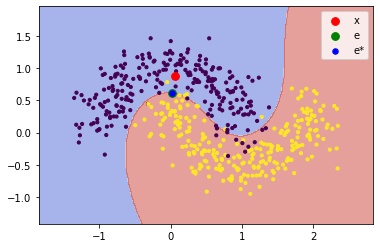

In [234]:
np.random.seed(5)
visualise(svm, X_data, Y_data, X_train, 0.01)

coordonées de x : [0.05380322 0.88455857]
coordonées de e : [0.0129236  0.58917661]
coordonées de e* : [0.05380322 0.58917661]


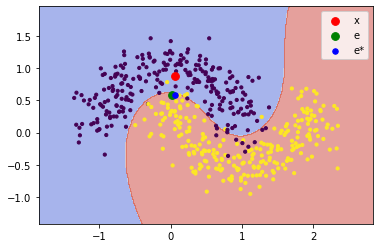

In [235]:
np.random.seed(5)
visualise(svm, X_data, Y_data, X_train, 0.1)

coordonées de x : [0.05380322 0.88455857]
coordonées de e : [0.02240802 0.58581044]
coordonées de e* : [0.05380322 0.58581044]


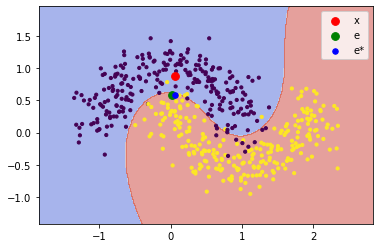

In [236]:
np.random.seed(5)
visualise(svm, X_data, Y_data, X_train, 0.5)

On observe que lorsque l'épaisseur de la couche sphérique est très faible (0.01) l'exemple contrefactuel e* est le même que l'exemple intermédiaire e. Cela peut s'expliquer par le fait que l'exemple e se trouve alors très proche de la frontière et qu'en ayant une couche sphérique très fine la modification d'un attribut entraîne immédiatement un changement dans la prédiction de la classe du point. 

Lorsque cette épaisseur est plus importante (0.1 et 0.5), la zone de la couche sphérique correspondant à la classe enemy sera plus importante (on ne se contente pas de froler la zone enemy). Il y aura donc plus de points dans cette couche sphérique qui seront de la classe enemy et on pourra plus facilement trouver un point avec une même coordonnée que le point x qui soit de classe opposée. 

### Stability

#### SVM

coordonées de x : [0.12050357 1.06417397]
coordonées de e : [0.01491885 0.60147468]
coordonées de e* : [0.01491885 0.60147468]


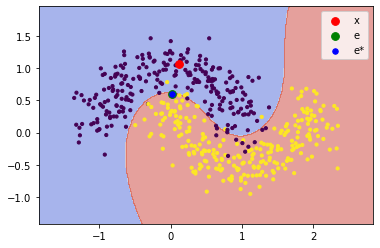

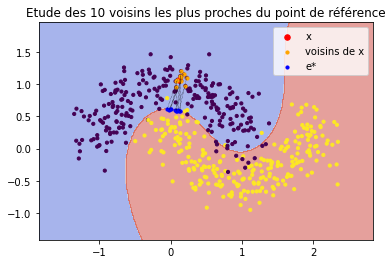

In [237]:
visualise(svm, X_data, Y_data, X_train, stable=True)

#### k-ppv

coordonées de x : [-0.06715677  0.97892912]
coordonées de e : [0.0378554  0.59259271]
coordonées de e* : [0.0378554  0.59259271]


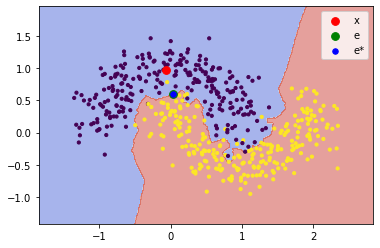

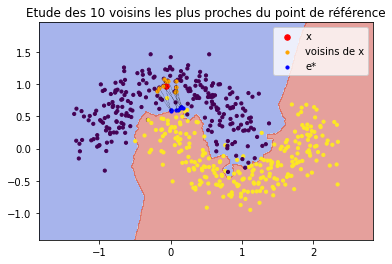

In [238]:
visualise(knn, X_data, Y_data, X_train, stable=True)

#### foret aléatoire

coordonées de x : [-1.00780084  0.04448683]
coordonées de e : [-0.56187484 -0.1093295 ]
coordonées de e* : [-0.56187484 -0.1093295 ]


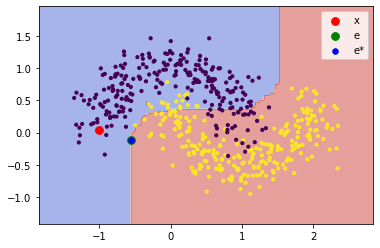

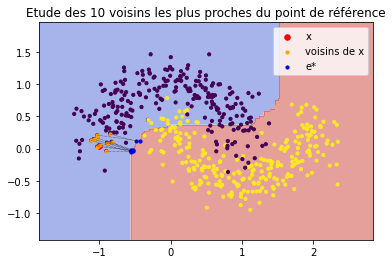

In [239]:
visualise(forest, X_data, Y_data, X_train, stable=True)

On observe que quelque soit le classifieur utilisé, les exemples contrefactuels des voisins du point de référence sont également dans un même voisinage. Cela dénote d'une certaine stabilité de l'algorithme. Il arrive même que plusieurs voisins de x soient expliqués par le même exemple contrefactuel comme on le voit très bien avec le classifieur random forest. 

coordonées de x : [1.10031364 0.4707814 ]
coordonées de e : [1.19873226 0.46891609]
coordonées de e* : [1.19873226 0.46891609]


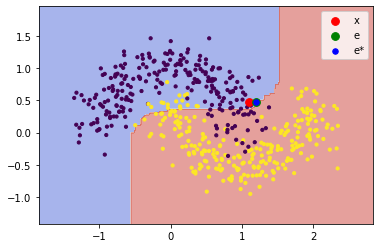

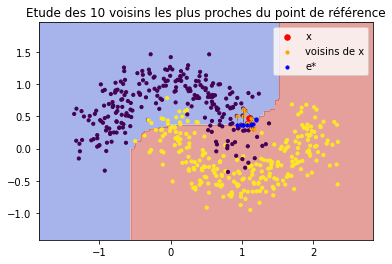

In [240]:
np.random.seed(42)
visualise(forest, X_data, Y_data, X_train, stable=True)

On observe ici que, même dans le cas où les points se trouve dans une zone où la fontière de décision a été mal délimitée par le classifieur et donc où les exemples contrefactuels sont normalement de la même classe que les points initiaux, l'algorithme reste stable.

### Sparcity

In [241]:
def sparcity(f, X): 
    
    nb_dimensions_differentes=[]
    for x in X:
        e = GS(f,x,0.1,100)
        e_star = feature_selection(f,x,e)

        nb_dim_diff = np.count_nonzero(x != e_star)
        
        nb_dimensions_differentes.append(nb_dim_diff)

    plt.hist(nb_dimensions_differentes, bins=range(max(nb_dimensions_differentes)+2), align = 'left', rwidth=0.5 )
    plt.xticks(range(max(nb_dimensions_differentes)+2))
    plt.xlabel('Nombre d\' attributs modifiées')
    plt.ylabel('Nombre d\'éléments')
    plt.title("Histogramme du nombre d'attributs différents entre x et e*")
    plt.grid(True)
    plt.show()

#### SVM

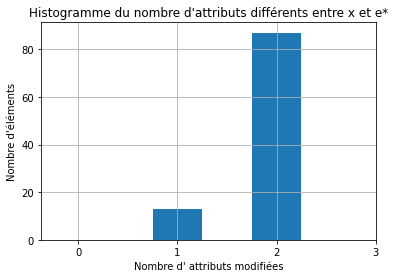

In [242]:
sparcity(svm, X_test)

####  k-ppv

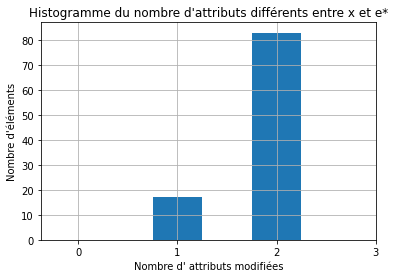

In [243]:
sparcity(knn, X_test)

#### foret aléatoire

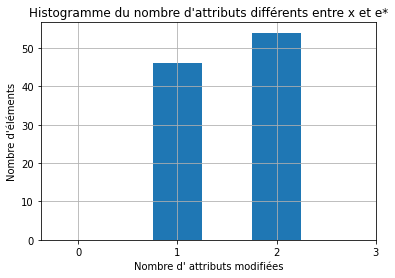

In [244]:
sparcity(forest, X_test)

On observe que l'utilisation des classifieurs SVM et KNN entraine le plus souvent la modification de deux attributs pour trouver les contrefactuels e* des différents points x. Cela signifie que chaque observation de l'ensemble de données de test a besoin de modifier 2 coordonnées ou moins pour franchir la frontière de décision. Le fait que toutes les coordonnées doivents souvent être modifiées pour trouver l'exemple contrefactuel peut s'expliquer par le faible nombre de dimensions de notre dataset. 

Dans le cas du classifieur random forest environ la moitié des points peuvent être expliqués par un exemple contrefactruel dont le une seule dimension a été modifiée (et l'autre moitié dont deux dimensions ont été modifiée). Cela peut s'expliquer par le fait la frontière de décision est faite de telle manière que pour la moitié des points, le changement d'une des deux coordonées de x suffira à changer la classe du point.

### which attribute

In [245]:
def which_attribute(f, X, y_labels):
    print(X[0])
    att = np.zeros(len(X[0]))

    for x in X :
        e = GS(f,x,0.1,100)
        e_star = feature_selection(f,x,e)

        att_diff = np.where(e != e_star)
        att[att_diff]+=1
    
    
    angles = np.linspace(0, 2*np.pi, len(y_labels), endpoint=False)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, att, 'o-', linewidth=2)
    ax.fill(angles, att, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, y_labels)
    ax.set_title("Attribut modifié")
    ax.grid(True)
    plt.show()

#### SVM

[ 1.11779686 -0.95315481]


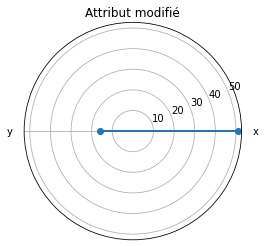

In [246]:
which_attribute(svm, X_data, ['x','y'])

####  k-ppv

[ 1.11779686 -0.95315481]


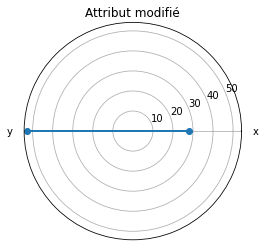

In [247]:
which_attribute(knn, X_data, ['x','y'])

#### foret aléatoire

[ 1.11779686 -0.95315481]


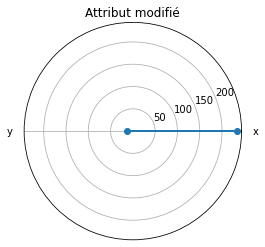

In [248]:
which_attribute(forest, X_data, ['x','y'])

Ici, seuls deux attributs (x et y) sont considérés. On observe que pour les classifieurs SVM et random forest c'est majoritairement l'attribut x qui est modifié tandis que pour le classifieur KNN c'est généralement l'attribut y. 

## 6. Expérimentations sur données classiques

### Dataframe Wine

In [249]:
data = datasets.load_wine()

In [250]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [251]:
data.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [252]:
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

### Classifieurs

In [253]:
svm.fit(X_data_train, y_data_train)


SVC()

In [254]:
yhat = svm.predict(X_data_test)
print("accuracy : ", accuracy_score(y_data_test,yhat))

accuracy :  0.8055555555555556


In [255]:
knn.fit(X_data_train, y_data_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=2)

In [256]:
yhat = knn.predict(X_data_test)
print("accuracy : ", accuracy_score(y_data_test,yhat))

accuracy :  0.7222222222222222


In [257]:
forest.fit(X_data_train, y_data_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [258]:
yhat = forest.predict(X_data_test)
print("accuracy : ", accuracy_score(y_data_test,yhat))

accuracy :  0.9444444444444444


De la même manière qu'auparavant, nous entraînons les classifieurs SVM, kNN et forêt aléatoire, mais cette fois-ci sur des jeux de données de dimensions supérieures : 178 exemples décrits par 13 attributs. On observe que c'est la forêt aléatoire qui affiche la meilleure performance avec une accuracy de 0.94, bien que SVM et kNN obtiennent des précisions acceptables de 0.80 et 0.72 respectivement.



### Sparcity

#### SVM

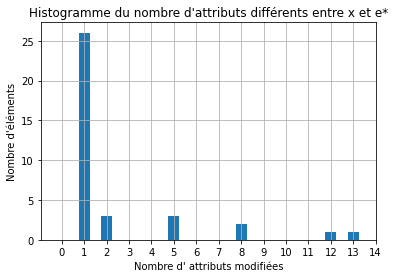

In [259]:
sparcity(svm, X_data_test)

####  k-ppv

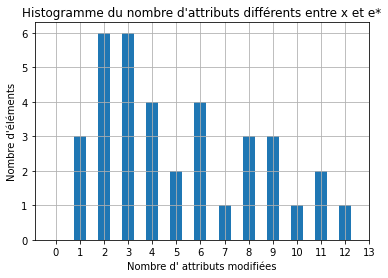

In [260]:
sparcity(knn, X_data_test)

#### foret aléatoire

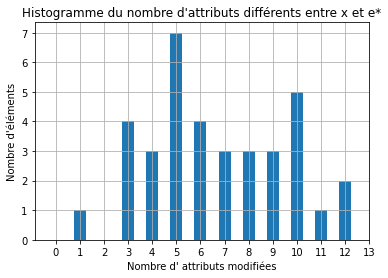

In [261]:
sparcity(forest, X_data_test)

Nous observons qu'avec le classifieur SVM, une grande partie des données n'a besoin de modifier qu'un attribut pour franchir la frontière de décision. Cela montre que la méthode proposée parvient effectivement à obtenir de la parcimonie afin de rendre les explications plus lisibles.

Dans le cas du classifieur KNN et random forest, il est plus rare qu'un seul attribut suffise à expliquer l'observation.

### which attribute

#### SVM

[1.364e+01 3.100e+00 2.560e+00 1.520e+01 1.160e+02 2.700e+00 3.030e+00
 1.700e-01 1.660e+00 5.100e+00 9.600e-01 3.360e+00 8.450e+02]


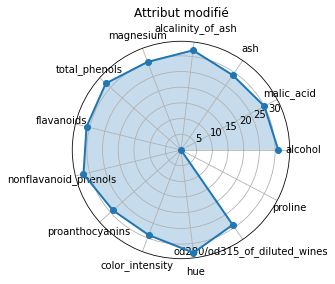

In [262]:
which_attribute(svm, X_data_test, data.feature_names)

####  k-ppv

[1.364e+01 3.100e+00 2.560e+00 1.520e+01 1.160e+02 2.700e+00 3.030e+00
 1.700e-01 1.660e+00 5.100e+00 9.600e-01 3.360e+00 8.450e+02]


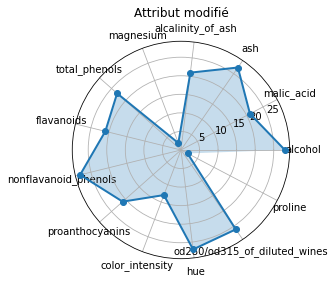

In [263]:
which_attribute(knn, X_data_test, data.feature_names)

#### foret aléatoire

[1.364e+01 3.100e+00 2.560e+00 1.520e+01 1.160e+02 2.700e+00 3.030e+00
 1.700e-01 1.660e+00 5.100e+00 9.600e-01 3.360e+00 8.450e+02]


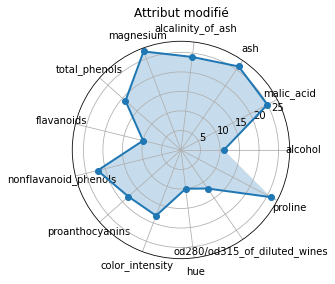

In [264]:
which_attribute(forest, X_data_test, data.feature_names)

Lorsque nous utilisons un SVM, on remarque que tous les attributs sont modifiés avec une intensité similaire à l'exception de l''attribut 'proline' qui n'est jamais modifié et ne sert donc pas à expliquer l'observation.
Dans le cas du classifieur KNN, ce sont les attributs proline et magnesium qui permettent rarement d'expliquer l'observation. 
Enfin, pour le classifieur random forest, certains attributs sont plus souvent modifés que d'autre. 

Ces différences dans le comportement des classifieurs met en évidence la façon dont chaque algorithme aborde la modification des caractéristiques lors de la génération de contre-factuels

Par ailleurs, le fait que dans le cas du classifieur SVM par exemple, presque la totalité des attributs sont modifiés pour obtenir l'exemple contrefactuel ne signifie pas qu'il y ait à chaque fois besoin de tous ces attributs pour expliquer l'observation. En effet, comme vu précédemment, dans le cas du SVM, pour un exemple donné, un attribut suffit généralement à expliquer l'observation. Il n'y a donc pas un attribut précis qui permette dans tous les cas l'explication de l'observation. 

De même, pour le classifieur random forest où il faut souvent 5 attributs pour expliquer l'observation, on ne sait ici pas quelle combinaison d'attribut fournit l'explications.

# Conlusion


L'approche post-hoc des growing spheres permet de générer des explications pour un exemple donné en comparant l'observation associée à celle-ci avec son ennemi le plus proche. Cependant cet algorithme repose sur une heuristique, il n'est donc pas sûr de trouver une solution.
Cette méthode utilise une fonction de coût prenant en compte la proximité (distance euclidiennne, norme l2) et la concision (norme l0) des explications. Les expérimentations menées dénote une certaine stabilité et parcimonie permettant de fournir des explications plus lisibles. 

Cependant, la génération d'exemples est faite sans considération des données existantes ce qui fait que l'on peut, théoriquement, avoir des explications hors de la distribution de nos données. On peut donc possiblement avoir une explication non réaliste.
De plus, la question de l'actionnabilité de l'explication peut se poser. En effet, si par exemple l'attribut x correspond à l'âge d'une personne, il est possible ici d'avoir un exemple contrefactuel avec un attribut x plus faible alors qu'il ne serait pas possible dans les faits de diminuer l'âge de la personne. 